### Package Install

This doesn't need to be run every time.  The cell is set to "Raw", you'll need to change it to a "Code" or "Python" cell to execute it.

# Object Detection of Pedestrians

In this notebook we'll fine-tune a Faster R-CNN model to detect pedestrian in the [Penn-Fudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/).  It consists of 170 images with 345 labeled pedestrians taken on two university campuses.  You should have read the textbook to get an idea of how the Faster R-CNN model works so we'll focus here on two main things.  First, we'll look at the Mean Average Precision (mAP) metric for evaluating how well an objective detection model both identifies and localizes objects.  Second, we'll examine how we can filter out redundant and low-confidence predicted boxes.

<iframe
    width="560"
    height="315"
    src="https://www.youtube.com/embed/FppOzcDvaDI"
    frameborder="0"
    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture"
    allowfullscreen>
</iframe>

In object detection, **Mean Average Precision (mAP)** is a key metric for evaluating how well a model identifies and localizes multiple object types within an image. Here are the core concepts:

### Key Concepts of mAP for Object Detection

1. **Intersection over Union (IoU)**:
   - **IoU** measures the overlap between a predicted bounding box and the ground truth bounding box. It is calculated as:
     \[
     \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
     \]
   - IoU values range from 0 to 1, where values closer to 1 indicate a high overlap, meaning the prediction closely matches the ground truth. IoU thresholds, often 0.5 and 0.75, determine the minimum overlap required for a correct detection.

2. **True Positives (TP), False Positives (FP), and False Negatives (FN)**:
   - A **True Positive** occurs when a predicted bounding box matches a ground truth box with IoU above the threshold.
   - A **False Positive** occurs when a predicted box does not match any ground truth box (IoU below threshold) or detects a non-existent object.
   - A **False Negative** occurs when a ground truth box has no matching predicted box, indicating the model missed detecting an actual object.

3. **Precision and Recall**:
   - **Precision** measures how many of the detected objects are correct, calculated as:
     \[
     \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
     \]
   - **Recall** measures how many actual objects the model detected, calculated as:
     \[
     \text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
     \]
   - Precision and Recall are typically calculated at multiple IoU thresholds (e.g., 0.5, 0.75) to reflect different levels of localization accuracy.

4. **Precision-Recall Curve and Average Precision (AP)**:
   - For each IoU threshold, a **Precision-Recall curve** is plotted by varying the confidence threshold of detections.
   - The **Average Precision (AP)** at each IoU threshold is the area under the Precision-Recall curve, providing a measure of the model’s accuracy at that IoU level.

5. **Mean Average Precision (mAP)**:
   - **mAP** is the mean of AP values across multiple IoU thresholds and classes.
   - In multi-class detection, mAP averages AP across both classes and IoU thresholds, providing a single score representing the model’s overall detection and localization performance across object types.

### Applying mAP to One-Class Detection Problems
In a single-class object detection task (e.g., detecting pedestrians or lesions), mAP still measures localization accuracy and detection reliability but focuses on just one object type. Here’s how mAP applies specifically to single-class detection:

- **Simplified IoU Thresholds**: For single-class problems, a single IoU threshold (e.g., 0.5) can suffice. This is known as mAP@0.5 and indicates the model’s accuracy in detecting and localizing objects of that class at a moderate level of overlap.
- **Single Precision-Recall Curve**: Instead of averaging AP across classes, a single Precision-Recall curve is created for the one object class. The AP value from this curve reflects the model’s detection accuracy for the class.
- **Interpretability**: A higher mAP score (closer to 1) means the model consistently detects and localizes instances of the single class with minimal false positives and missed detections, simplifying performance interpretation compared to multi-class problems.

**Intuitive Explanation for mAP:**

mAP, or mean Average Precision, measures how well a model detects objects by considering both **precision** (accuracy of predictions) and **recall** (coverage of ground truth objects). In essence, mAP tells you how well the model balances detecting **all instances** of an object while also keeping **false positives** (incorrect detections) low.

In a single-class problem, mAP captures how accurately and consistently the model detects objects of that class across different confidence thresholds. A high mAP means the model is good at finding and correctly classifying instances of the object.

**What mAP@50 and mAP@50:95 Mean for a Single-Class Problem:**

- **mAP@50**: This calculates the model's precision and recall at an Intersection over Union (IoU) threshold of 0.5. In simpler terms, a detection counts as correct if it overlaps with the ground truth by at least 50%. So, mAP@50 measures the model's ability to find objects without being overly strict about the exact position and size of the bounding box.

- **mAP@50:95**: This is a stricter metric that averages the mAP across IoU thresholds from 0.5 to 0.95 in steps of 0.05 (0.5, 0.55, …, 0.95). Here, the model needs to get closer to the actual object boundary to achieve a high score, making mAP@50:95 a more challenging but comprehensive measure of detection accuracy. It requires the model not just to detect objects but also to have precise bounding box localization.

In a single-class problem, mAP@50 gives a good indication of basic detection performance, while mAP@50:95 is more demanding and reflects both detection and precise localization quality.

In [2]:
# uncomment to use a custom environment file
from dotenv import load_dotenv
load_dotenv('../mac.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from graphics_and_data_prep import display_images_and_boxes



MODELS_PATH=PosixPath('/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=PosixPath('/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=PosixPath('/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/downloads')


In [3]:
class PennFudanDetect(Dataset):
    """
    Custom Dataset for Penn-Fudan Database for Pedestrian Detection and Segmentation.
    Args:
        root (str or Path): Root directory of the dataset.
        transforms (callable, optional): A function/transform that takes in an image and target and returns a transformed version.
        split (str, optional): Dataset split, either 'train' or 'val'. Default is 'train'.
        seed (int, optional): Random seed for shuffling the dataset. Default is 42.
    Attributes:
        imgs (list): List of image file paths.
        masks (list): List of mask file paths.
        split (str): Dataset split, either 'train' or 'val'.
        seed (int): Random seed for shuffling the dataset.
    Methods:
        __getitem__(idx):
            Args:
                idx (int): Index of the item to be fetched.
            Returns:
                tuple: (image, target) where target is a dictionary containing 'boxes' and 'labels'.
        __len__():
            Returns:
                int: Number of items in the dataset.
    """
    def __init__(self, root, transforms=None, split='train', seed=42):
        self.root = Path(root)
        self.transforms = transforms
        self.split = split
        self.seed = seed

        # Load all image and mask files
        imgs = sorted((self.root / "PNGImages").iterdir())
        masks = sorted((self.root / "PedMasks").iterdir())

        # Ensure reproducibility with a fixed seed
        indices = list(range(len(imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

        # Assign the split based on the parameter
        if split == 'train':
            self.indices = train_indices
        elif split == 'val':
            self.indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        # Subset the images and masks according to the split
        self.imgs = [imgs[i] for i in self.indices]
        self.masks = [masks[i] for i in self.indices]

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = read_image(str(img_path)).float() / 255.0  # Normalize to [0, 1]
        mask = read_image(str(mask_path))

        # Prepare masks and bounding boxes
        obj_ids = torch.unique(mask)[1:]  # Exclude background (first ID)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # Single class

        # Create tv_tensor types
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:]),
            "labels": labels,
        }

        # Apply transformations
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [4]:
# Define training transformations
train_transforms = T.Compose([
    T.RandomHorizontalFlip(0.5),  # Random horizontal flip with 50% probability
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color jitter
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Define validation transformations (no data augmentation, just tensor conversion)
val_transforms = T.Compose([
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanDetect(root=dataset_path, split='train', transforms=train_transforms)
val_dataset = PennFudanDetect(root=dataset_path, split='val', transforms=val_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

# define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [11]:
# model configuration
model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone_name = 'resnet50'  # Using ResNet-50 for better performance
weights = "DEFAULT"   # Use pretrained weights

# Initialize the Faster R-CNN model with a ResNet-50 backbone
backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # MPS doesn't work with Faster R-CNN
model.to(device)

# training configuration
initial_lr = 0.005  # Initial learning rate
weight_decay = 0.0005
patience = 5  # Early stopping patience

# Training parameters
num_epochs = 15
patience = 3

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Initialize mAP metrics for validation
map_metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])

# Function to train one epoch with optional validation
def train_one_epoch(model, optimizer, train_loader, val_loader, device):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += losses.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model.eval()  # Switch to eval mode to get predictions
    val_running_loss = 0.0
    map_metric.reset()  # Reset metrics before validation

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Get model predictions without targets to avoid returning losses
            outputs = model(images)
            
            # Format outputs and targets for torchmetrics
            formatted_outputs = [
                {k: v.cpu() for k, v in output.items()} for output in outputs
            ]
            formatted_targets = [
                {k: (v.cpu() if isinstance(v, torch.Tensor) else v) for k, v in target.items()} for target in targets
            ]
            
            # Update mAP metric with formatted outputs and targets
            map_metric.update(formatted_outputs, formatted_targets)
            
            # Temporarily switch to training mode to compute validation loss
            model.train()
            loss_dict = model(images, targets)
            val_losses = sum(loss for loss in loss_dict.values())
            val_running_loss += val_losses.item()
            
            # Switch back to eval mode for the next prediction
            model.eval()

    # Calculate mAP metrics
    avg_val_loss = val_running_loss / len(val_loader)
    map_metrics = map_metric.compute()
    map_50 = map_metrics['map_50']
    map_50_95 = map_metrics['map']
    
    return avg_train_loss, avg_val_loss, map_50, map_50_95

# Early stopping setup
best_map_50_95 = 0.0
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Train and validate for the epoch
    avg_train_loss, avg_val_loss, map_50, map_50_95 = train_one_epoch(model, optimizer, train_loader, val_loader, device)
    
    epoch_str = (f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                 f"Val Loss: {avg_val_loss:.4f}, mAP@50: {map_50:.4f}, mAP@50-95: {map_50_95:.4f}")

    # Check for improvement in mAP@50-95
    if map_50_95 > best_map_50_95:
        best_map_50_95 = map_50_95
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_save_path)
        epoch_str += " New best mAP@50-95. Model weights saved."
    else:
        epochs_without_improvement += 1

    print(epoch_str)

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs with no improvement in mAP@50-95.")
        break

    # Step the scheduler based on mAP@50-95
    scheduler.step(map_50)

# If training completes without early stopping, save the final model
if epochs_without_improvement < patience:
    torch.save(model.state_dict(), model_save_path)
    print(f"Training complete. Final model weights saved.")


Epoch [1/15], Train Loss: 0.3897, Val Loss: 0.2847, mAP@50: 0.5323, mAP@50-95: 0.2739 New best mAP@50-95. Model weights saved.
Epoch [2/15], Train Loss: 0.2403, Val Loss: 0.1932, mAP@50: 0.5137, mAP@50-95: 0.2707
Epoch [3/15], Train Loss: 0.1919, Val Loss: 0.1870, mAP@50: 0.8646, mAP@50-95: 0.5424 New best mAP@50-95. Model weights saved.
Epoch [4/15], Train Loss: 0.1753, Val Loss: 0.1939, mAP@50: 0.9343, mAP@50-95: 0.7312 New best mAP@50-95. Model weights saved.
Epoch [5/15], Train Loss: 0.1701, Val Loss: 0.1932, mAP@50: 0.9636, mAP@50-95: 0.6790
Epoch [6/15], Train Loss: 0.1583, Val Loss: 0.1875, mAP@50: 0.9680, mAP@50-95: 0.7488 New best mAP@50-95. Model weights saved.
Epoch [7/15], Train Loss: 0.1559, Val Loss: 0.1774, mAP@50: 0.9514, mAP@50-95: 0.7057
Epoch [8/15], Train Loss: 0.1425, Val Loss: 0.1525, mAP@50: 0.9564, mAP@50-95: 0.8057 New best mAP@50-95. Model weights saved.
Epoch [9/15], Train Loss: 0.1369, Val Loss: 0.1541, mAP@50: 0.9675, mAP@50-95: 0.8643 New best mAP@50-95. M

In [5]:

model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights="DEFAULT")
model = FasterRCNN(backbone, num_classes=2)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu'), weights_only=True));
model.eval();

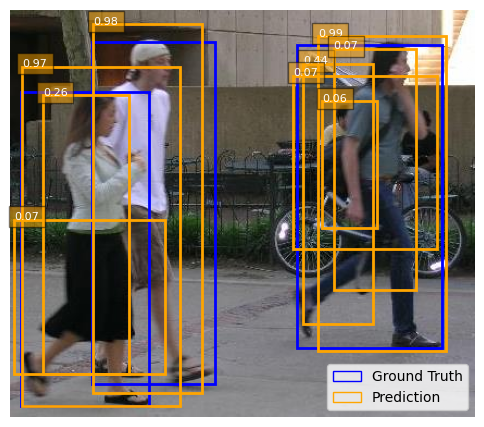

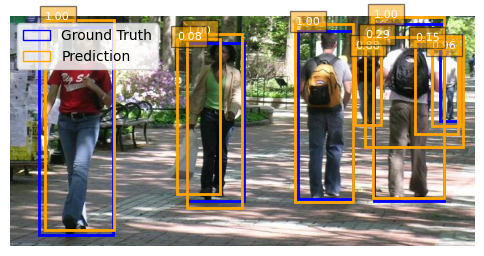

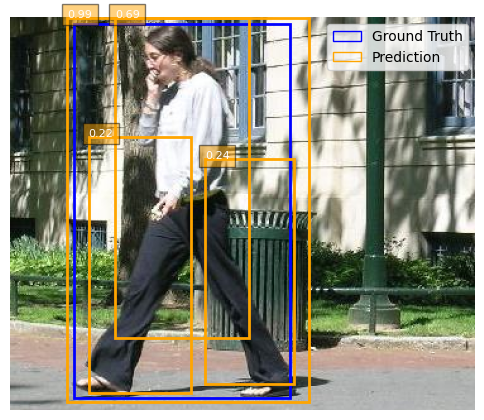

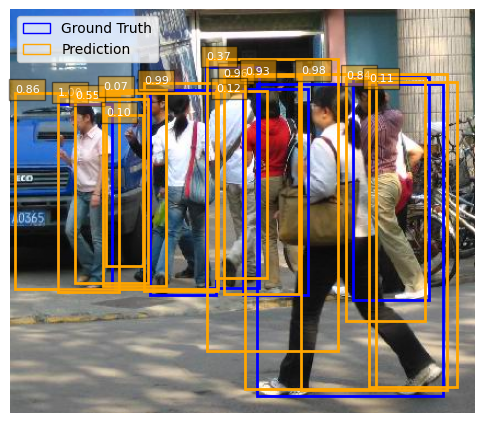

In [7]:
# Display random samples with ground truth and predictions with no filtering
selected_images = [0,4,6,16]
display_images_and_boxes(val_dataset, model=model, indices=selected_images,denormalize=False, 
                         confidence_threshold=0.0, iou_threshold=1.0, show_confidence=True)

"""
Performs Non-Maximum Suppression (NMS) and confidence filtering for object detection.

Non-Maximum Suppression (NMS):
NMS is a technique used to eliminate redundant or overlapping bounding boxes in object detection. 
It selects the bounding box with the highest confidence score and suppresses all other boxes that 
have a high overlap (Intersection over Union, IoU) with the selected box. This helps in reducing 
multiple detections of the same object.

Confidence Filtering:
Confidence filtering involves removing bounding boxes that have a confidence score below a certain 
threshold. This helps in eliminating low-confidence detections, thereby improving the precision 
of the object detection model.
"""

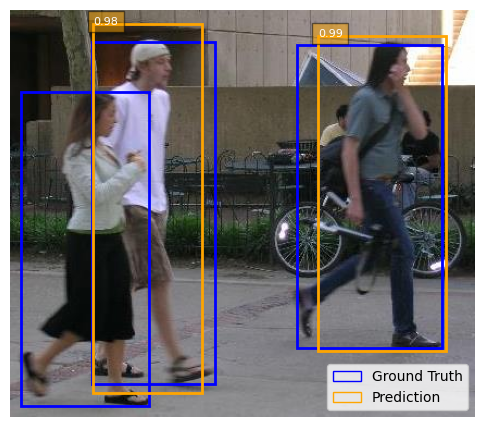

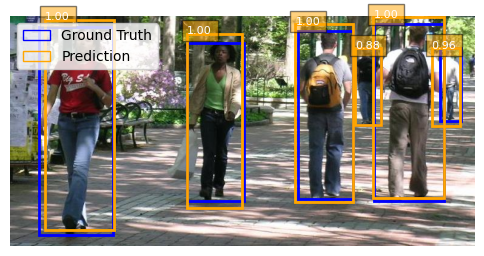

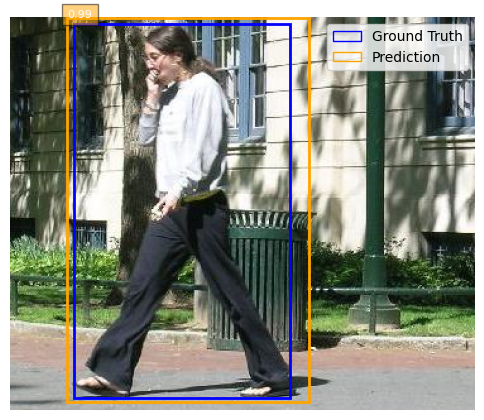

In [11]:
# Display random samples with ground truth and predictions with no filtering
display_images_and_boxes(val_dataset, model=model, indices=selected_images, confidence_threshold=.5, iou_threshold = 0.4, denormalize=False, show_confidence=True)

In [ ]:
import pandas as pd

def train_one_epoch(model, optimizer, train_loader, val_loader, device, map_metric):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += losses.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model.eval()  # Switch to eval mode to get predictions
    val_running_loss = 0.0
    map_metric.reset()  # Reset metrics before validation

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Get model predictions without targets to avoid returning losses
            outputs = model(images)
            
            # Format outputs and targets for torchmetrics
            formatted_outputs = [
                {k: v.cpu() for k, v in output.items()} for output in outputs
            ]
            formatted_targets = [
                {k: (v.cpu() if isinstance(v, torch.Tensor) else v) for k, v in target.items()} for target in targets
            ]
            
            # Update mAP metric with formatted outputs and targets
            map_metric.update(formatted_outputs, formatted_targets)
            
            # Temporarily switch to training mode to compute validation loss
            model.train()
            loss_dict = model(images, targets)
            val_losses = sum(loss for loss in loss_dict.values())
            val_running_loss += val_losses.item()
            
            # Switch back to eval mode for the next prediction
            model.eval()

    # Calculate mAP metrics
    avg_val_loss = val_running_loss / len(val_loader)
    map_metrics = map_metric.compute()
    map_50 = map_metrics['map_50']
    map_50_95 = map_metrics['map']
    
    return avg_train_loss, avg_val_loss, map_50, map_50_95


def train_model(model, optimizer, scheduler, train_loader, val_loader, device, save_file, num_epochs=15, patience=3):
    # Initialize mAP metrics for validation
    map_metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])

    # Early stopping setup
    best_map_50_95 = 0.0
    epochs_without_improvement = 0

    # DataFrame to store results
    results = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'map_50', 'map_50_95', 'lr'])

    for epoch in range(num_epochs):
        # Train and validate for the epoch
        avg_train_loss, avg_val_loss, map_50, map_50_95 = train_one_epoch(model, optimizer, train_loader, 
                                                                          val_loader, device, map_metric)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Append results to DataFrame
        results.loc[len(results)] = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'map_50': map_50,
            'map_50_95': map_50_95,
            'lr': current_lr
        }

        epoch_str = (f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                     f"Val Loss: {avg_val_loss:.4f}, mAP@50: {map_50:.4f}, mAP@50-95: {map_50_95:.4f}, LR: {current_lr:.6f}")

        # Check for improvement in mAP@50-95
        if map_50_95 > best_map_50_95:
            best_map_50_95 = map_50_95
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_file)
            epoch_str += " New best mAP@50-95. Model weights saved."
        else:
            epochs_without_improvement += 1

        print(epoch_str)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement in mAP@50-95.")
            break

        # Step the scheduler based on mAP@50-95
        scheduler.step(map_50)

    # If training completes without early stopping, save the final model
    if epochs_without_improvement < patience:
        torch.save(model.state_dict(), save_file)
        print(f"Training complete. Final model weights saved.")

    return results



In [17]:
# model configuration
save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan_2.pth"
backbone_name = 'resnet50' 
weights = "DEFAULT"

backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # MPS doesn't work with Faster R-CNN
model.to(device)

# training configuration
initial_lr = 0.005  # Initial learning rate
weight_decay = 0.0005
patience = 5  # Early stopping patience

# Training parameters
num_epochs = 15
patience = 3

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Example usage
results = train_model(model, optimizer, scheduler, train_loader, val_loader, device, save_file=save_path, num_epochs=15, patience=5)
print(results)


AttributeError: 'DataFrame' object has no attribute 'append'

# Develop Fancy Display

In [ ]:
model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights="DEFAULT")
model = FasterRCNN(backbone, num_classes=2)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu'), weights_only=True));
model.eval();

In [51]:
def predict_boxes(dataset, index, model, mean=None, std=None):
    """
    Predict bounding boxes and labels for a given image in the dataset.

    Parameters:
    - dataset: The dataset containing the images and ground truth annotations.
    - index: The index of the image to predict on.
    - model: The object detection model.
    - mean: The mean values for normalization (default: None).
    - std: The standard deviation values for normalization (default: None).

    Returns:
    - image: The denormalized image.
    - gt_boxes: The ground truth bounding boxes.
    - gt_labels: The ground truth labels.
    - pred_boxes: The predicted bounding boxes.
    - pred_scores: The predicted scores.
    - pred_labels: The predicted labels.
    """
    image, target = dataset[index]

    if mean is not None and std is not None:
        image = denormalize_torch(image, mean, std)

    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        output = model([image.to(device)])[0]

    gt_boxes = target["boxes"].cpu().numpy() if "boxes" in target else None
    gt_labels = target["labels"].cpu().numpy() if "labels" in target else None
    pred_boxes = output["boxes"].cpu().detach().numpy()
    pred_scores = output["scores"].cpu().detach().numpy()
    pred_labels = output["labels"].cpu().detach().numpy()

    return image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels

image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels = predict_boxes(val_dataset, 0, model)

In [52]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_image_with_dropdown(image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, iou_threshold=0, conf_threshold=0):
    """
    Display an image with ground truth and predicted bounding boxes, and sliders to adjust the thresholds.

    Parameters:
    - image: The image to display (NumPy array or PyTorch tensor).
    - gt_boxes: The ground truth bounding boxes.
    - gt_labels: The ground truth labels.
    - pred_boxes: The predicted bounding boxes.
    - pred_scores: The predicted scores.
    - pred_labels: The predicted labels.
    - iou_threshold: The IoU threshold for color coding.
    - conf_threshold: The confidence threshold for filtering.
    """
    # Convert image to NumPy array if it is a PyTorch tensor
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    class_names = np.unique(np.concatenate((gt_labels, pred_labels)))
    dropdown = widgets.Dropdown(options=class_names, description='Class:')
    iou_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=iou_threshold, description='IoU Threshold:')
    conf_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=conf_threshold, description='Confidence Threshold:')
    output = widgets.Output()

    def on_dropdown_change(change):
        selected_class = change['new']
        output.clear_output()
        selected_gt_boxes = gt_boxes[gt_labels == selected_class] if gt_boxes is not None else None
        selected_pred_boxes = pred_boxes[pred_labels == selected_class]
        selected_pred_scores = pred_scores[pred_labels == selected_class]
        selected_pred_labels = pred_labels[pred_labels == selected_class]
        with output:
            display_image_with_boxes(image, gt_boxes, gt_labels,
                                     selected_pred_boxes, selected_pred_scores, selected_pred_labels,
                                     iou_slider.value, conf_slider.value, selected_class)

    def on_slider_change(change):
        on_dropdown_change({'new': dropdown.value})

    dropdown.observe(on_dropdown_change, names='value')
    iou_slider.observe(on_slider_change, names='value')
    conf_slider.observe(on_slider_change, names='value')
    on_dropdown_change({'new': class_names[0]})

    display(widgets.VBox([dropdown, iou_slider, conf_slider, output]))

def display_image_with_boxes(image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, iou_threshold, conf_threshold, selected_class):
    """
    Display an image with ground truth and predicted bounding boxes, and apply color coding based on thresholds.
    Also display precision and recall in the top right.

    Parameters:
    - image: The image to display (NumPy array or PyTorch tensor).
    - gt_boxes: The ground truth bounding boxes.
    - gt_labels: The ground truth labels.
    - pred_boxes: The predicted bounding boxes.
    - pred_scores: The predicted scores.
    - pred_labels: The predicted labels.
    - iou_threshold: The IoU threshold for color coding.
    - conf_threshold: The confidence threshold for filtering.
    - selected_class: The selected class for calculating precision and recall.
    """
    # Convert image to NumPy array if it is a PyTorch tensor
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    # Calculate figure size based on the image dimensions to keep an appropriate aspect ratio
    height, width, _ = image.shape
    fig_height = height / 80  # Scale factor to get reasonable figure height
    fig_width = width / 80    # Scale factor to get reasonable figure width

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.imshow(image)

    # Display ground truth boxes (always show all ground truth boxes)
    if gt_boxes is not None:
        for box, label in zip(gt_boxes, gt_labels):
            x, y, w, h = box
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='blue')
            ax.add_patch(rect)
            ax.text(x, y, label, color='blue', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Variables to calculate precision and recall
    true_positive = 0
    false_positive = 0
    matched_gt_indices = set()

    # Display predicted boxes for the selected class and calculate precision/recall
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= conf_threshold:
            # Filter ground truth boxes and labels to only those matching the current predicted label
            matching_gt_boxes = gt_boxes[gt_labels == label]
            if len(matching_gt_boxes) > 0:
                iou_values = calculate_iou(box, matching_gt_boxes)
                max_iou_idx = np.argmax(iou_values)
                max_iou = iou_values[max_iou_idx]

                if max_iou >= iou_threshold and max_iou_idx not in matched_gt_indices:
                    color = 'green'
                    true_positive += 1
                    matched_gt_indices.add(max_iou_idx)
                else:
                    color = 'red'
                    false_positive += 1
            else:
                color = 'red'
                false_positive += 1

            x, y, w, h = box
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color)
            ax.add_patch(rect)
            ax.text(x, y, f'{label}: {score:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Count false negatives (ground truth boxes not matched by any predicted box)
    matching_gt_boxes = gt_boxes[gt_labels == selected_class]
    false_negative = len(matching_gt_boxes) - len(matched_gt_indices)

    # Calculate precision and recall
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    # Display precision and recall
    ax.text(0.95, 0.05, f'Precision: {precision:.2f}\nRecall: {recall:.2f}', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))

    plt.axis('off')
    plt.show()

def calculate_iou(box, gt_boxes):
    """
    Calculate the IoU (Intersection over Union) between a predicted box and a list of ground truth boxes.

    Parameters:
    - box: The predicted box, in the format (x_min, y_min, x_max, y_max).
    - gt_boxes: The ground truth boxes, in the format (x_min, y_min, x_max, y_max).

    Returns:
    - The IoU value for each ground truth box.
    """
    # Convert predicted box format (x, y, w, h) to (x_min, y_min, x_max, y_max)
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height

    # Calculate intersection coordinates
    gt_x_min = gt_boxes[:, 0]
    gt_y_min = gt_boxes[:, 1]
    gt_x_max = gt_boxes[:, 0] + gt_boxes[:, 2]
    gt_y_max = gt_boxes[:, 1] + gt_boxes[:, 3]

    inter_x_min = np.maximum(x_min, gt_x_min)
    inter_y_min = np.maximum(y_min, gt_y_min)
    inter_x_max = np.minimum(x_max, gt_x_max)
    inter_y_max = np.minimum(y_max, gt_y_max)

    # Calculate intersection area
    inter_width = np.maximum(0, inter_x_max - inter_x_min)
    inter_height = np.maximum(0, inter_y_max - inter_y_min)
    intersection = inter_width * inter_height

    # Calculate areas of predicted and ground truth boxes
    box_area = width * height
    gt_areas = (gt_x_max - gt_x_min) * (gt_y_max - gt_y_min)

    # Calculate union area
    union = box_area + gt_areas - intersection

    # Calculate IoU
    iou = intersection / union

    return iou


In [53]:
display_image_with_dropdown(image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)